# Predecir el precio de las casas en Melbourne

# Pasos Previos

## Importación de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb

## Importamos los datos

In [2]:
dforg = pd.read_csv("archives/Melbourne_housing_FULL.csv")
dforg.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


# Código

## Matriz de correlación pre-limpieza

<Axes: >

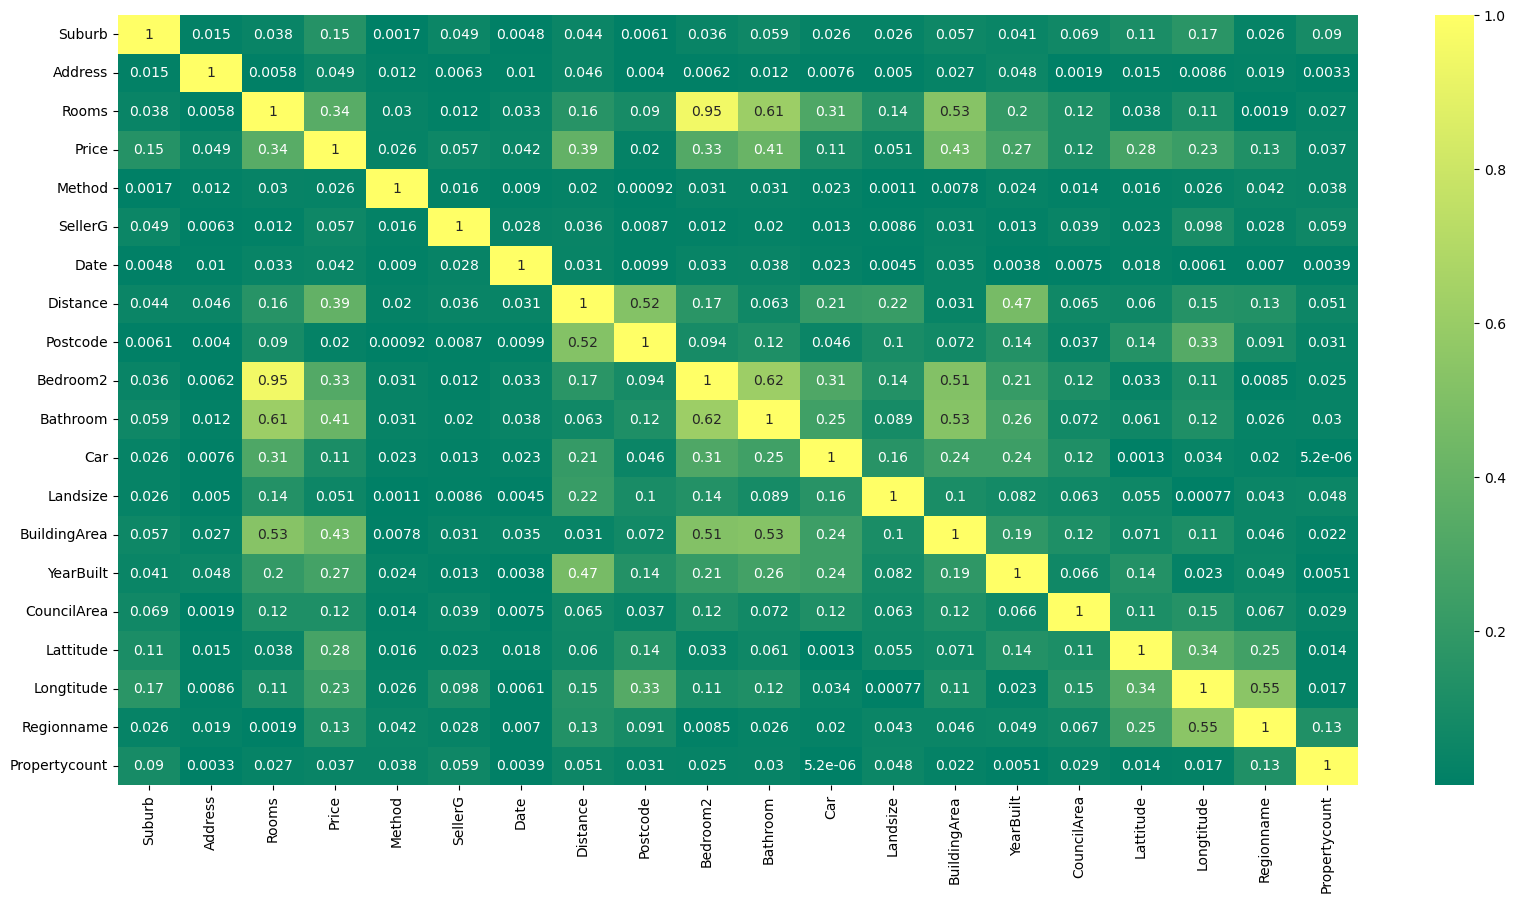

In [3]:
df = dforg.copy()

# Solo me interesas las casas (houses)
df = df[df["Type"] == "h"]

# No nos interesa tener la columna 'Type' ya que todas van a ser 'h'
df.drop(["Type"], axis=1, inplace=True)

# Borramos todos los nulos ya que querevemos ver la correlación entre las columnas con el precio
df.dropna(inplace=True)

# Paso los valores no numéricos a numéricos
ordinal_encoder = OrdinalEncoder()
lcolumns = ["Suburb", "Address", "Method","SellerG","Regionname", "CouncilArea","Date"]

for column in lcolumns:
    column_encoded = ordinal_encoder.fit_transform(df[[column]])
    df[column] = column_encoded

# Creo la matriz de correlación 
corr_matrix = df.corr()

# Muestro un mapa de calor con la matriz de correlación
plt.figure(figsize=(20,10))
sns.heatmap(np.abs(corr_matrix), annot=True, cmap='summer')

## Limpieza de Datos Inicial

- En base al heatmap anterior podemos decidir que columnas borrar y cuales buscar una manera de rellenar los datos

In [4]:
df = dforg.copy()
# Solo me interesas las casas (houses)
df = df[df["Type"] == "h"]

# Eliminando Columnas (basandome en el heatmap anterior) <0.1
df.drop(["Address" , "Method" , "SellerG" , "Date" , "Postcode", "Type", "Landsize"], axis=1, inplace=True)

# Si la fila tiene mucho nulos no me interesa 
# ya que con tantos nulos no podría rellenarlos con un valor (media/mediana/moda)
df = df[df.isna().sum(axis=1) < 4]

# Eliminando nulos que son necesarios para determinar el precio (heatmap)
df.dropna(subset=["Price", "Distance","Lattitude","Longtitude"], inplace=True) 

# Cambiando el tipo de columnas (para su mejor visualización)
df["YearBuilt"] = df["YearBuilt"].astype("Int64")

df.isna().sum()

Suburb              0
Rooms               0
Price               0
Distance            0
Bedroom2            0
Bathroom            0
Car               364
BuildingArea     7776
YearBuilt        6983
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

## Matriz de correlación

- Con esta matiz de correlación podemos ver que las siguientes columnas tienen una correlación baja:
    - Car
    - PropertyCount
    - CouncilArea
    - Regionname
    - Suburb

<Axes: >

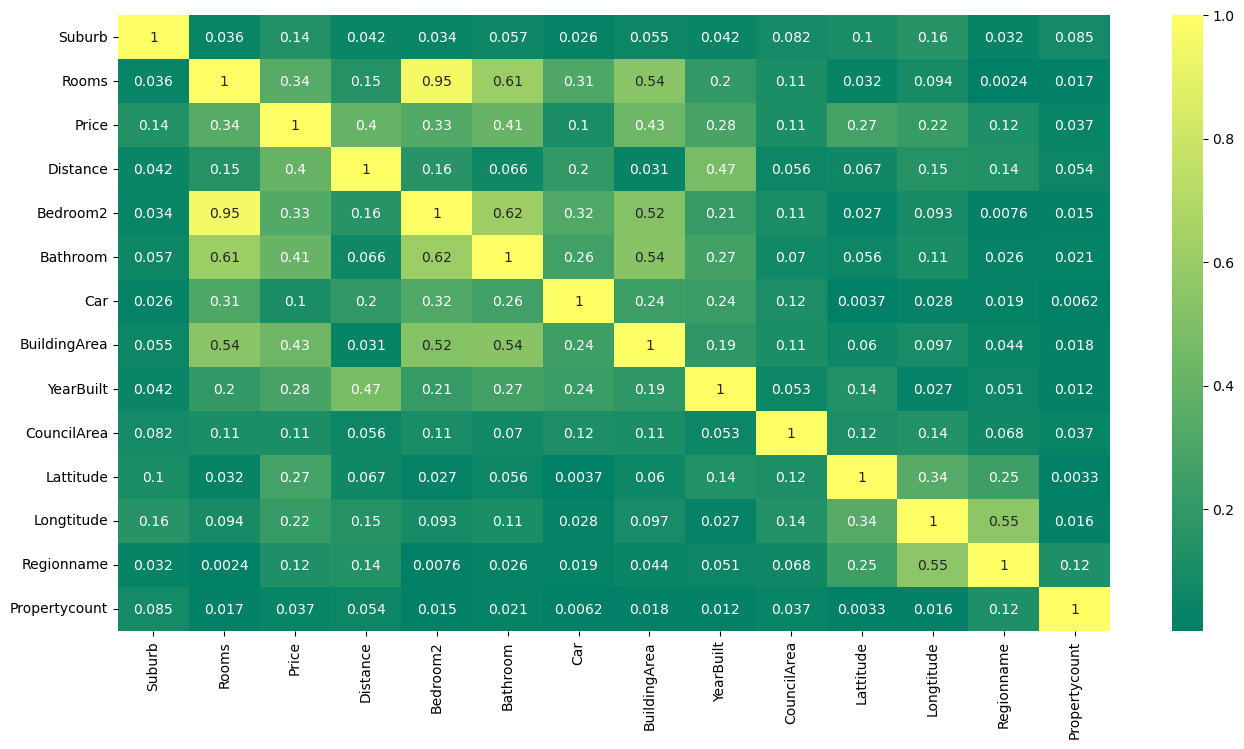

In [5]:
ordinal_encoder = OrdinalEncoder()
lcolumns = ["Suburb", "CouncilArea", "Regionname"]

for column in lcolumns:
    column_encoded = ordinal_encoder.fit_transform(df[[column]])
    df[column] = column_encoded

# Hago una matriz sin los nulos para que me de el resultado lo mas exacto posible
corr_matrix = df.dropna().corr()

plt.figure(figsize=(16,8))
sns.heatmap(np.abs(corr_matrix), annot=True, cmap='summer')

## Modelo

### División de datos

- Primero dividimos los datos
    - Podemos hacerlo utilizando la funcion comentada o utilizar una función propia de sklearn

In [6]:
# df.dropna(inplace=True)

# Corr > 0.2
# x = df.drop(["Car","Propertycount","CouncilArea","Regionname","Suburb", "Price"],axis=1)

# Corr > 0.1
x = df.drop(["Price"],axis=1)

x = SimpleImputer(strategy="most_frequent").fit_transform(x)
y = df["Price"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### Métodos

In [7]:
lscores = {}

def results(model, model_reg):
    predicciones = model_reg.predict(x_test)
    mse = mean_squared_error(y_test, predicciones)
    mse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predicciones)
    score = r2_score(y_test, predicciones)
    print(f"mae: {mae}   rmse: {mse} r2_score: {score}")
    lscores[model] = {}
    lscores[model]["error"] = {}
    lscores[model]["error"]["mae"] = mae
    lscores[model]["error"]["mse"] = mse
    lscores[model]["score"] = score

def validation(model, model_reg):
    lin_score = cross_val_score(model_reg, x_train, y_train,
                            scoring = "neg_mean_squared_error", cv=10)
    root_lin_score = np.sqrt(-lin_score)
    lscores[model]["validation"] = {}
    lscores[model]["validation"]["scores"] = list(root_lin_score)
    lscores[model]["validation"]["mean"] = root_lin_score.mean()
    lscores[model]["validation"]["std"] = root_lin_score.std()
    print("scores ",lscores[model]["validation"]["scores"])    
    print("mean ",lscores[model]["validation"]["mean"])
    print("std ",lscores[model]["validation"]["std"])    

### Modelo Linear

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)

print("PREDICCIONES: ",lin_reg.predict(x_test[:5]))
print("Reales: ", list(y_test[:5]))

PREDICCIONES:  [1287374.84446514  668703.79487062  861634.17499954 1082688.92740804
 1816240.41628703]
Reales:  [846000.0, 786000.0, 538000.0, 1260000.0, 1400000.0]


#### Resultado Linear

In [9]:
results("linear", lin_reg)

mae: 326045.79608194693   rmse: 935687.86613193 r2_score: -0.8717505619215902


#### Validacion lineal

In [10]:
validation("linear", lin_reg)

scores  [508361.9639951381, 456104.9388007419, 418956.7669803908, 464884.28359645745, 464704.42437203095, 602793.1245112044, 448157.8106633112, 490004.65436276514, 442940.03794485907, 470312.0463832435]
mean  476722.0051610142
std  48079.21074030664


### Modelo de Arbol

In [11]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(x_train, y_train)

print("PREDICCIONES: ",tree_reg.predict(x_test[:5]))
print("Reales: ", list(y_test[:5]))

PREDICCIONES:  [1200000.  650000.  710000. 1050000. 1600000.]
Reales:  [846000.0, 786000.0, 538000.0, 1260000.0, 1400000.0]


#### Resultado Arbol

In [12]:
results("tree", tree_reg)

mae: 261107.88008482745   rmse: 430155.7742630467 r2_score: 0.6044171171680375


#### Validacion en arbol

In [13]:
validation("tree", tree_reg)

scores  [491043.29646057874, 402592.77736312576, 447303.4116144052, 474376.0805914429, 434546.8843339287, 572413.8536284438, 544344.1259313277, 550249.5353230226, 418486.6141600499, 512321.75068507483]
mean  484767.83300914
std  56122.426519738


### Modelo random forest

In [14]:
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(x_train, y_train)

print("PREDICCIONES: ",rf_reg.predict(x_test[:5]))
print("Reales: ", list(y_test[:5]))

PREDICCIONES:  [1249495.    688015.    686040.   1147265.   1680158.98]
Reales:  [846000.0, 786000.0, 538000.0, 1260000.0, 1400000.0]


#### Resultado random forest

In [15]:
results("forest", rf_reg)

mae: 192215.7919125653   rmse: 325862.5405165847 r2_score: 0.7729848427032521


#### Validación Forest

In [16]:
validation("forest", rf_reg)

scores  [406871.69865820935, 301313.48439000634, 303672.3828233234, 319910.77152752044, 316953.6016643283, 464026.57191071956, 320579.7686476698, 336529.7595135931, 323020.8339957799, 354161.2709536003]
mean  344704.0144084751
std  49256.689464967996


### Modelo SVM

In [17]:
sv_reg = SVR()
sv_reg.fit(x_train, y_train)

print("PREDICCIONES: ",sv_reg.predict(x_test[:5]))
print("Reales: ", list(y_test[:5]))

PREDICCIONES:  [1019964.21390139 1019895.46795759 1019895.57044618 1020000.24872445
 1019917.65950151]
Reales:  [846000.0, 786000.0, 538000.0, 1260000.0, 1400000.0]


#### Resultado SVM

In [18]:
results("svm", sv_reg)

mae: 467285.46070430265   rmse: 713383.8959343162 r2_score: -0.08800922939699873


#### Validacion SVM

In [19]:
validation("svm", sv_reg)

scores  [722617.0420585335, 652572.0119295688, 659050.1835483548, 703929.6542459697, 670314.656982995, 841904.6490613106, 674943.8819529604, 706737.6139619558, 669504.8752360559, 718996.0784486146]
mean  702057.0647426319
std  52338.43356442936


### Modelo XGboost

In [20]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror")
xgb_reg.fit(x_train, y_train)

print("PREDICCIONES: ", xgb_reg.predict(x_test[:5]))
print("Reales: ", list(y_test[:5]))

PREDICCIONES:  [1184011.6   786746.56  695473.6  1078272.9  1555117.6 ]
Reales:  [846000.0, 786000.0, 538000.0, 1260000.0, 1400000.0]


#### Resultado XGboost

In [21]:
results("xgboost", xgb_reg)

mae: 197347.07331429535   rmse: 331970.86486854416 r2_score: 0.7643942329545506


#### Validación XGboost

In [22]:
validation("xgboost", xgb_reg)

scores  [412532.22302097984, 318480.31352466374, 284404.7744550842, 341086.3810582158, 308624.8326542348, 456930.78055923915, 306500.56519475125, 320506.9227198164, 328370.2373934228, 349832.0228736011]
mean  342726.9053454009
std  50132.81390096737


### Resultados 

- Corr > 0.1 - dropna                       
    - linear -------- 0.5111252779258119                        
    - tree -------- 0.6043790095634156                      
    - forest -------- 0.7482805795484463                        
    - svm -------- -0.08562516595140068                     
    - xgboost -------- 0.7350920883333146                       
-----------------------------------
- Corr > 0.1 - median
    - linear --------- -1.0893051689694295
    - tree --------- 0.6111690863084789
    - forest --------- 0.7720122396910943
    - svm --------- -0.08800921588843735
    - xgboost --------- 0.7697624328809675
-----------------------------------
- Corr > 0.1 - moda (most_frequent)
    - linear --------- -0.8717505619215646
    - tree --------- 0.5932999906826204
    - forest --------- 0.7709828701801704
    - svm --------- -0.08800922939699873
    - xgboost --------- 0.7627497804854191
-----------------------------------
- Corr > 0.2 - dropna
    - linear -------- 0.5125629803713041
    - tree -------- 0.5474816121702332
    - forest -------- 0.7532775758293949
    - svm -------- -0.08804954037090806
    - xgboost -------- 0.7548722534725925
-----------------------------------
- Corr > 0.2 - median
    - linear --------- -1.3550868610103088
    - tree --------- 0.5112412577401257
    - forest --------- 0.762259113698105
    - svm --------- -0.08798278806486826
    - xgboost --------- 0.75088397945009
-----------------------------------
- Corr > 0.2 - moda (most_frequent)
    - linear --------- -1.090296217963274
    - tree --------- 0.52342769267869
    - forest --------- 0.7589121794891084
    - svm --------- -0.08798348026031211
    - xgboost --------- 0.7520139888163141

In [23]:
for model in lscores:
    print(f"{model} --------- {lscores[model]['score']}")

linear --------- -0.8717505619215902
tree --------- 0.6044171171680375
forest --------- 0.7729848427032521
svm --------- -0.08800922939699873
xgboost --------- 0.7643942329545506
